<a href="https://colab.research.google.com/github/AkindeKadjo/Small-projects/blob/main/GAN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this GAN exercise, I'll use the fashion MNIST data to generate fasion items 

#Library Import & Data Loading

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [3]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

(60000, 28, 28)

#Getting the Data ready

In [5]:
#Reshaping the images by adding 1 dimension for the gray-scale channel
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [6]:
#Normalizing the images to [-1,1] since our generator output layer uses tanh, 255/2 = 127.5
train_images = (train_images - 127.5)/127.5

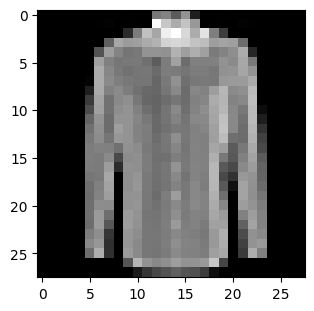

In [14]:
#check one of the images
figs = plt.subplots(figsize = (4,3), constrained_layout=True)
plt.imshow(train_images[3000].squeeze(), cmap ='gray')

In [15]:
#the training set data is divided by batches then shuffled
buffer_size = 60000
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

#Building the models

The generator uses tf.keras.layers.Dense layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then using Relu activations for each Dense layer.Note that activation in final layer is tanh which outputs in the range -1 to 1. we reshape the 784-d tensor to (Batch Size, 28, 28, 1) using layers.Reshape function

In [18]:
def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(64, input_dim = 100))
  model.add(layers.ReLU())

  model.add(layers.Dense(128))
  model.add(layers.ReLU())
    
  model.add(layers.Dense(256))
  model.add(layers.ReLU())

  model.add(layers.Dense(784, activation = 'tanh')) 
  model.add(layers.Reshape((28,28,1)))

  return model

In [19]:
#check generator summary
generator = generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                6464      
                                                                 
 re_lu_3 (ReLU)              (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 re_lu_4 (ReLU)              (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 re_lu_5 (ReLU)              (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 784)              

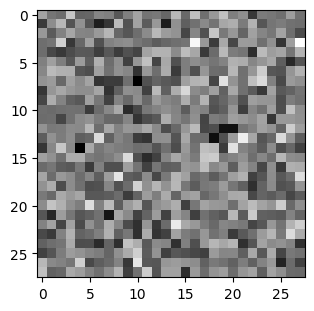

In [25]:
# Using the untrained generator to create a random gray sale image
noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)
figs = plt.subplots(figsize = (4,3), constrained_layout=True)
plt.imshow(generated_image[0], cmap='gray')

The discriminator is a binary classifier,it expects a tensor of shape (Batch Size, 28, 28, 1). We are flattening out input to feed it into Dense layers. 

The final layer has the sigmoid activation function, which squashes the output value between 0 (fake) and 1 (real).

Note that we can also leave the last layer without sigmoid activation and use_logits=True in Binary Cross entropy function(which is recommended).

In [26]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape = (28, 28, 1)))
    model.add(layers.Flatten())
  
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

In [27]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [28]:
#Here We are using the (as yet untrained) discriminator to classify the generated images as real or fake.
#The model will be trained to output values > 0.5 for real images, and values <0.5 for fake images.
output = discriminator(generated_image)
print (output)

tf.Tensor([[0.5577037]], shape=(1, 1), dtype=float32)


In [29]:
#Now We are defining loss functions. In this case it is Binary Cross entropy as target is real or fake images
bce = tf.keras.losses.BinaryCrossentropy()

In [30]:
#This method quantifies how well the discriminator is able to distinguish real images from fakes. 
#It compares the discriminator's predictions on real images to an array of 1s,
#and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):    
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)    
    total_loss = real_loss + fake_loss    
    return total_loss

In [31]:
#The generator's loss quantifies how well it was able to trick the discriminator. 
#Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). 
#Here, compare the discriminators decisions on the generated images to an array of 1s.
def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)  
    return gen_loss

In [32]:
#The discriminator and the generator optimizers are different since two networks would be trained separately.
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )

In [33]:
#Following code demonstrates how to save and restore models, 
#which can be helpful in case a long running training task is interrupted.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

We are using tf.function This annotation causes the function to be "compiled".

In [34]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [35]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [36]:
#Notice training is set to False. This is so all layers run in inference mode (batchnorm). Function for generating and plotting images is defined
def generate_and_plot_images(model, epoch, test_input):
  
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  
        pred = (predictions[i, :, :, 0] + 1) * 127.5  
        pred = np.array(pred)    
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [37]:
def train(dataset, epochs):
    
    gen_loss_list = []
    disc_loss_list = []
    
    real_score_list =[]
    fake_score_list =[]
    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)
        
        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches...')
        
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss
        
        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
           
        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%'  %
              (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)                 

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  
    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list    

Finally, it’s time to train our GAN model in Tensorflow. Taking the train_dataset and epochs as the parameters, the train function calls the train_step function, at every new batch.At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look more real.

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 469 batches...
Losses after epoch     1: generator 3.179, discriminator 0.269, real_score 95.33%, fake_score 7.88%


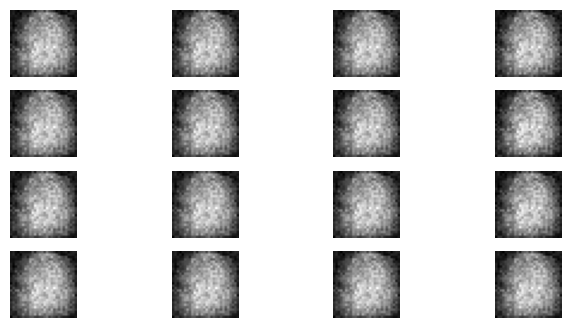

  2%|▏         | 1/50 [00:21<17:49, 21.83s/it]

Time for epoch 1 is 21.82583451271057 sec
Training started with  epoch 2 with 469 batches...
Losses after epoch     2: generator 8.236, discriminator 0.108, real_score 95.54%, fake_score 1.29%


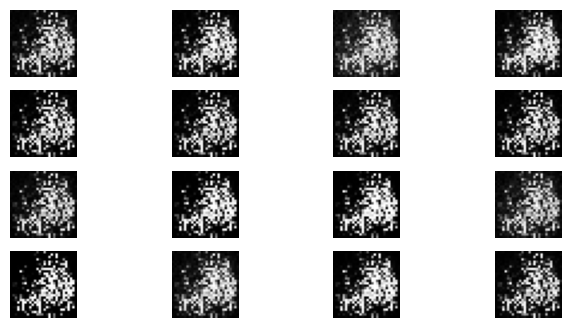

  4%|▍         | 2/50 [00:32<12:23, 15.49s/it]

Time for epoch 2 is 11.034023761749268 sec
Training started with  epoch 3 with 469 batches...
Losses after epoch     3: generator 3.971, discriminator 0.309, real_score 88.40%, fake_score 6.42%


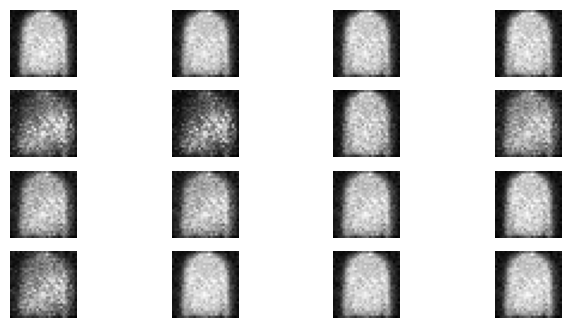

  6%|▌         | 3/50 [00:43<10:26, 13.32s/it]

Time for epoch 3 is 10.74166464805603 sec
Training started with  epoch 4 with 469 batches...
Losses after epoch     4: generator 3.325, discriminator 0.395, real_score 88.90%, fake_score 11.61%


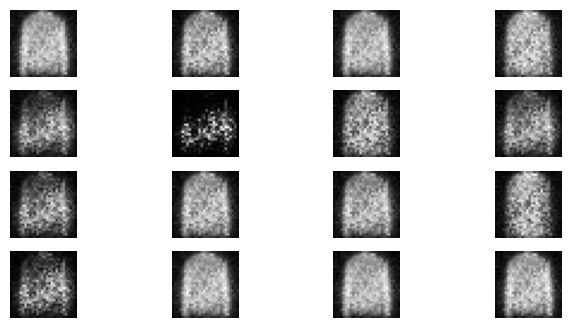

  8%|▊         | 4/50 [00:54<09:25, 12.29s/it]

Time for epoch 4 is 10.693506002426147 sec
Training started with  epoch 5 with 469 batches...
Losses after epoch     5: generator 2.063, discriminator 0.638, real_score 84.01%, fake_score 21.63%


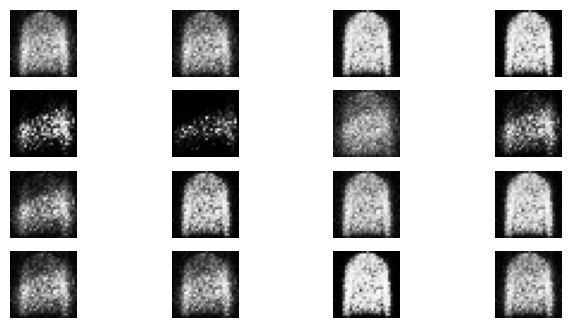

 10%|█         | 5/50 [01:04<08:42, 11.61s/it]

Time for epoch 5 is 10.40525197982788 sec
Training started with  epoch 6 with 469 batches...
Losses after epoch     6: generator 2.464, discriminator 0.358, real_score 91.20%, fake_score 14.51%


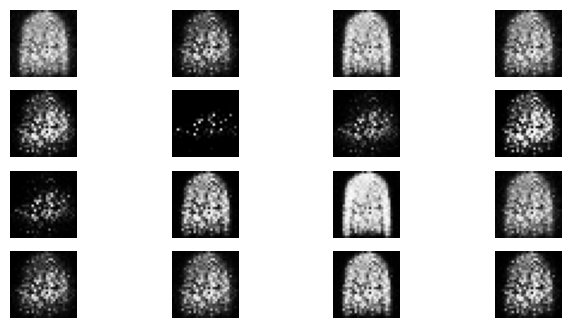

 12%|█▏        | 6/50 [01:14<08:07, 11.07s/it]

Time for epoch 6 is 10.016000032424927 sec
Training started with  epoch 7 with 469 batches...
Losses after epoch     7: generator 2.252, discriminator 0.512, real_score 90.77%, fake_score 22.98%


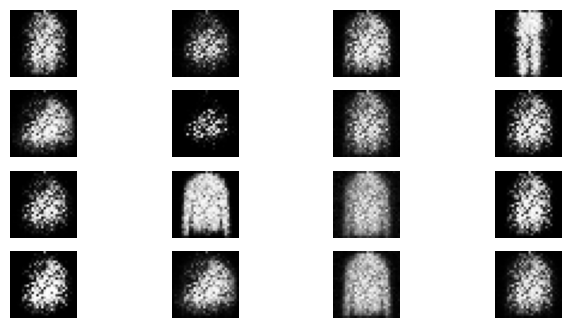

 14%|█▍        | 7/50 [01:25<07:55, 11.05s/it]

Time for epoch 7 is 10.999025106430054 sec
Training started with  epoch 8 with 469 batches...
Losses after epoch     8: generator 3.095, discriminator 0.412, real_score 93.03%, fake_score 17.90%


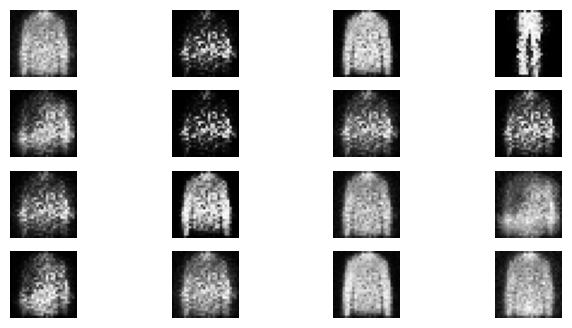

 16%|█▌        | 8/50 [01:37<07:53, 11.27s/it]

Time for epoch 8 is 11.7265784740448 sec
Training started with  epoch 9 with 469 batches...
Losses after epoch     9: generator 3.069, discriminator 0.300, real_score 90.43%, fake_score 10.87%


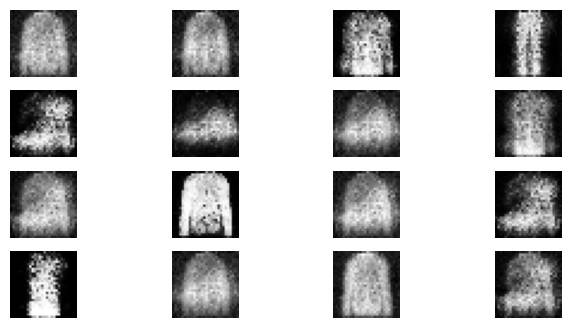

 18%|█▊        | 9/50 [01:48<07:36, 11.14s/it]

Time for epoch 9 is 10.8640296459198 sec
Training started with  epoch 10 with 469 batches...
Losses after epoch    10: generator 2.804, discriminator 0.633, real_score 81.23%, fake_score 17.56%


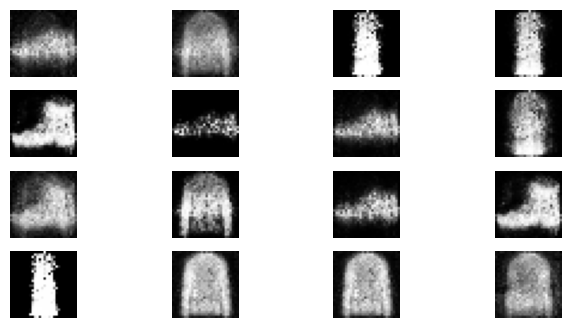

 20%|██        | 10/50 [01:59<07:30, 11.25s/it]

Time for epoch 10 is 11.49609661102295 sec
Training started with  epoch 11 with 469 batches...
Losses after epoch    11: generator 2.807, discriminator 0.464, real_score 85.96%, fake_score 14.40%


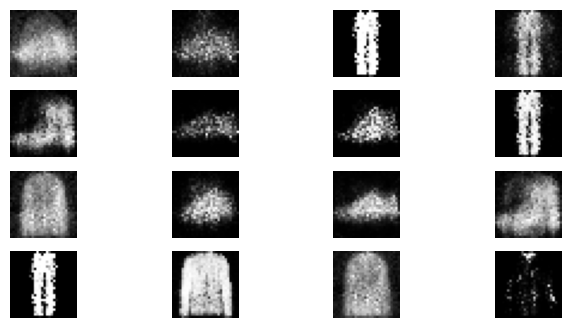

 22%|██▏       | 11/50 [02:10<07:12, 11.10s/it]

Time for epoch 11 is 10.751914024353027 sec
Training started with  epoch 12 with 469 batches...
Losses after epoch    12: generator 2.253, discriminator 0.879, real_score 81.94%, fake_score 24.95%


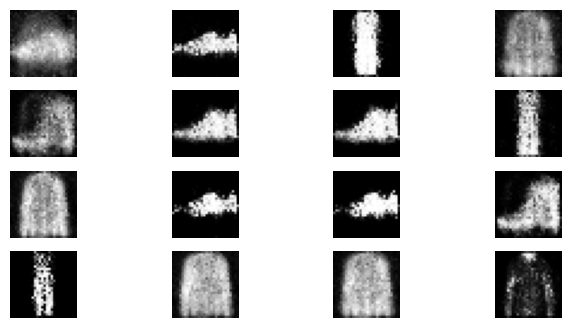

 24%|██▍       | 12/50 [02:23<07:27, 11.78s/it]

Time for epoch 12 is 13.313179731369019 sec
Training started with  epoch 13 with 469 batches...
Losses after epoch    13: generator 1.705, discriminator 0.876, real_score 78.75%, fake_score 29.81%


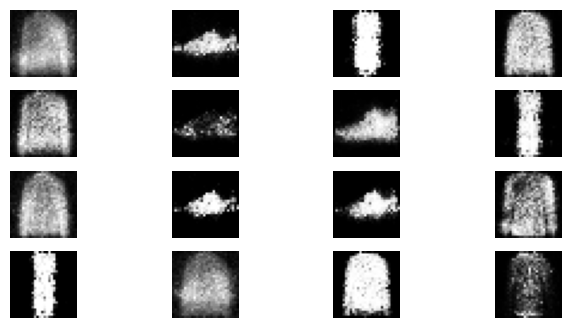

 26%|██▌       | 13/50 [02:33<06:55, 11.22s/it]

Time for epoch 13 is 9.952556610107422 sec
Training started with  epoch 14 with 469 batches...
Losses after epoch    14: generator 3.038, discriminator 0.652, real_score 82.19%, fake_score 13.41%


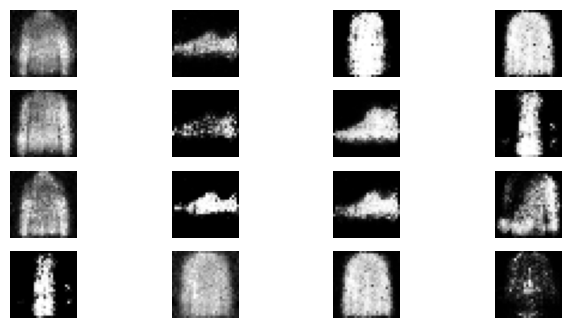

 28%|██▊       | 14/50 [02:43<06:31, 10.88s/it]

Time for epoch 14 is 10.0817129611969 sec
Training started with  epoch 15 with 469 batches...
Losses after epoch    15: generator 2.781, discriminator 0.789, real_score 73.60%, fake_score 15.24%


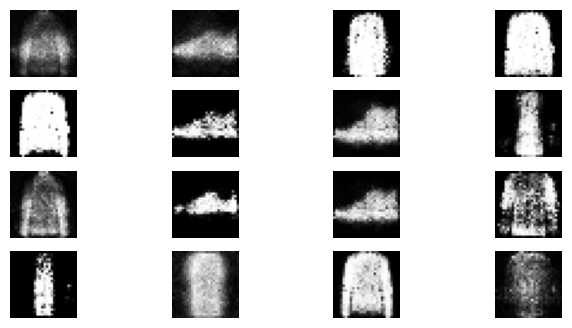

 30%|███       | 15/50 [02:54<06:21, 10.89s/it]

Time for epoch 15 is 10.91248607635498 sec
Training started with  epoch 16 with 469 batches...
Losses after epoch    16: generator 2.501, discriminator 0.570, real_score 81.74%, fake_score 16.14%


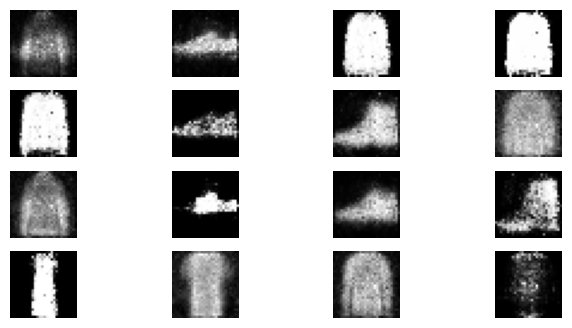

 32%|███▏      | 16/50 [03:05<06:06, 10.77s/it]

Time for epoch 16 is 10.476382970809937 sec
Training started with  epoch 17 with 469 batches...
Losses after epoch    17: generator 1.612, discriminator 0.811, real_score 75.69%, fake_score 29.22%


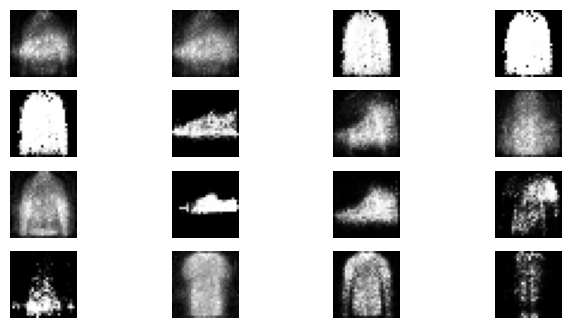

 34%|███▍      | 17/50 [03:15<05:53, 10.71s/it]

Time for epoch 17 is 10.584689378738403 sec
Training started with  epoch 18 with 469 batches...
Losses after epoch    18: generator 2.451, discriminator 0.588, real_score 83.52%, fake_score 18.57%


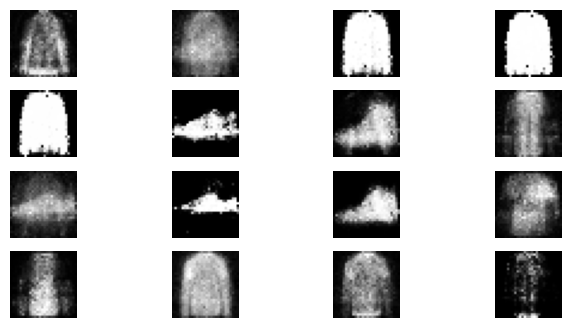

 36%|███▌      | 18/50 [03:26<05:40, 10.65s/it]

Time for epoch 18 is 10.490265130996704 sec
Training started with  epoch 19 with 469 batches...
Losses after epoch    19: generator 2.224, discriminator 0.534, real_score 83.52%, fake_score 17.99%


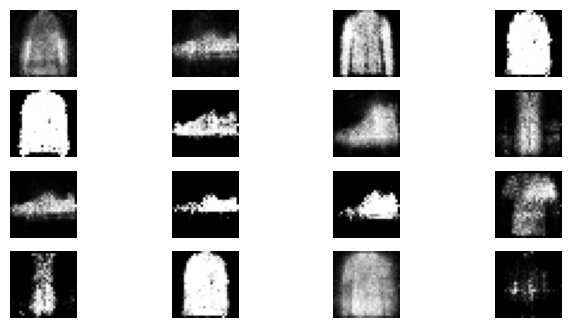

 38%|███▊      | 19/50 [03:36<05:23, 10.43s/it]

Time for epoch 19 is 9.905167818069458 sec
Training started with  epoch 20 with 469 batches...
Losses after epoch    20: generator 1.804, discriminator 0.661, real_score 83.78%, fake_score 25.17%


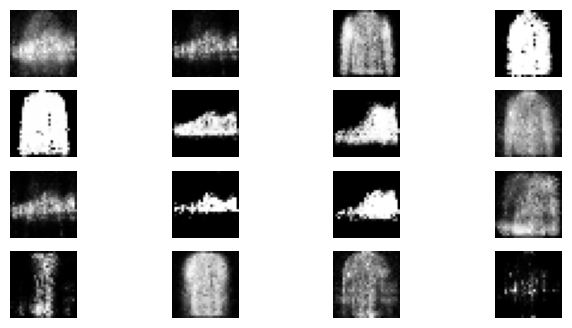

 40%|████      | 20/50 [03:47<05:16, 10.54s/it]

Time for epoch 20 is 10.804111957550049 sec
Training started with  epoch 21 with 469 batches...
Losses after epoch    21: generator 1.790, discriminator 0.783, real_score 77.55%, fake_score 26.68%


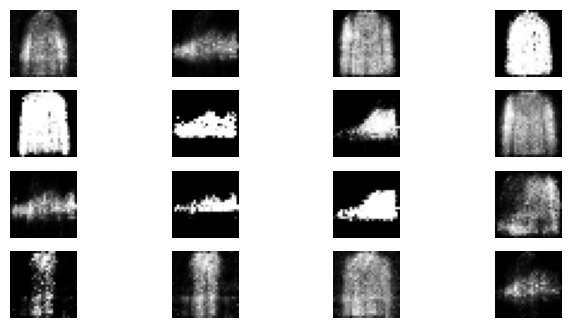

 42%|████▏     | 21/50 [03:57<05:04, 10.50s/it]

Time for epoch 21 is 10.387274503707886 sec
Training started with  epoch 22 with 469 batches...
Losses after epoch    22: generator 1.519, discriminator 0.973, real_score 69.62%, fake_score 28.46%


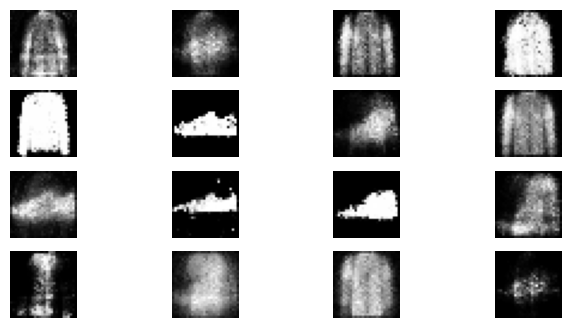

 44%|████▍     | 22/50 [04:08<04:54, 10.53s/it]

Time for epoch 22 is 10.60598874092102 sec
Training started with  epoch 23 with 469 batches...
Losses after epoch    23: generator 2.279, discriminator 0.507, real_score 86.57%, fake_score 18.76%


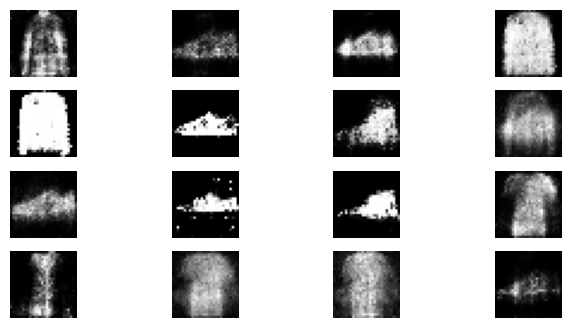

 46%|████▌     | 23/50 [04:18<04:44, 10.52s/it]

Time for epoch 23 is 10.507419347763062 sec
Training started with  epoch 24 with 469 batches...
Losses after epoch    24: generator 2.098, discriminator 0.641, real_score 79.76%, fake_score 21.12%


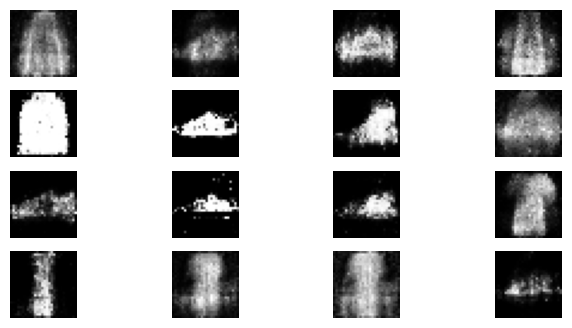

 48%|████▊     | 24/50 [04:28<04:29, 10.36s/it]

Time for epoch 24 is 9.960154056549072 sec
Training started with  epoch 25 with 469 batches...
Losses after epoch    25: generator 2.594, discriminator 0.482, real_score 83.49%, fake_score 15.63%


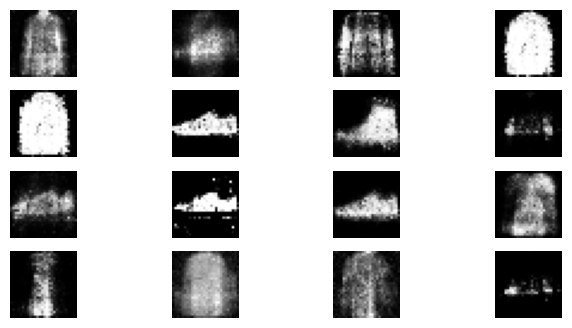

 50%|█████     | 25/50 [04:38<04:17, 10.28s/it]

Time for epoch 25 is 10.100625038146973 sec
Training started with  epoch 26 with 469 batches...
Losses after epoch    26: generator 2.145, discriminator 0.807, real_score 75.29%, fake_score 21.68%


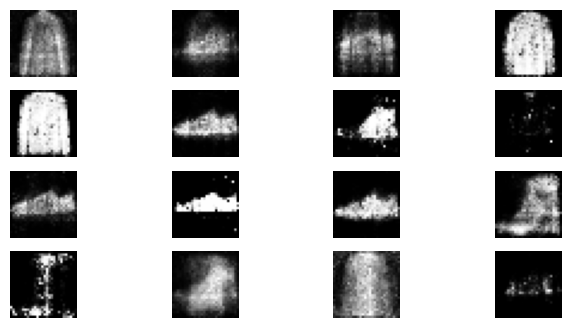

 52%|█████▏    | 26/50 [04:49<04:08, 10.36s/it]

Time for epoch 26 is 10.552839994430542 sec
Training started with  epoch 27 with 469 batches...
Losses after epoch    27: generator 2.720, discriminator 0.435, real_score 86.62%, fake_score 15.96%


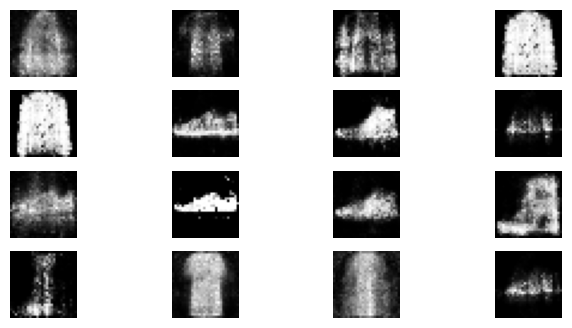

 54%|█████▍    | 27/50 [04:59<03:59, 10.43s/it]

Time for epoch 27 is 10.588423013687134 sec
Training started with  epoch 28 with 469 batches...
Losses after epoch    28: generator 1.268, discriminator 0.971, real_score 69.63%, fake_score 33.03%


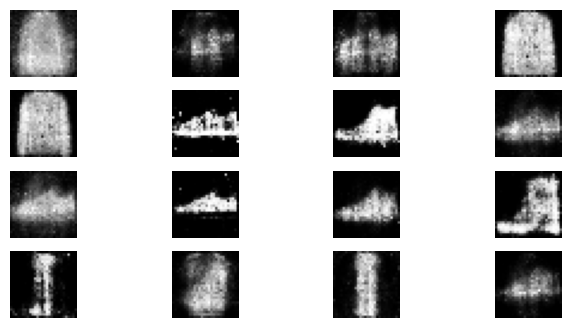

 56%|█████▌    | 28/50 [05:12<04:02, 11.04s/it]

Time for epoch 28 is 12.446576595306396 sec
Training started with  epoch 29 with 469 batches...
Losses after epoch    29: generator 2.360, discriminator 0.739, real_score 78.61%, fake_score 18.45%


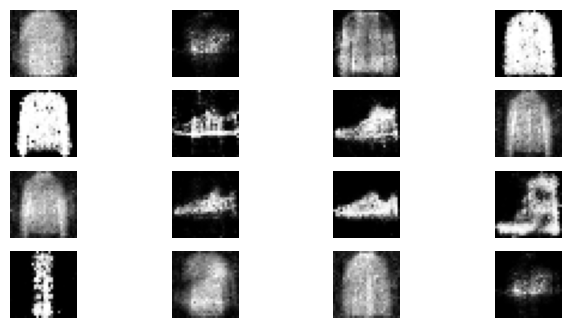

 58%|█████▊    | 29/50 [05:22<03:43, 10.62s/it]

Time for epoch 29 is 9.637191534042358 sec
Training started with  epoch 30 with 469 batches...
Losses after epoch    30: generator 2.552, discriminator 0.559, real_score 81.22%, fake_score 17.89%


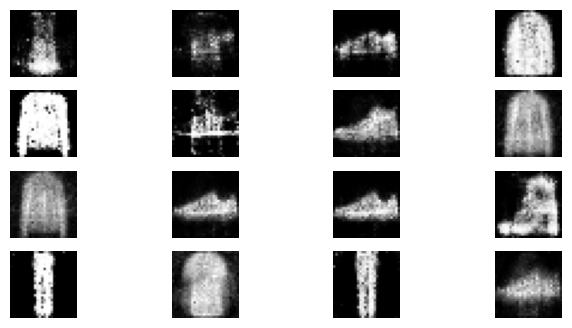

 60%|██████    | 30/50 [05:32<03:30, 10.52s/it]

Time for epoch 30 is 10.296846151351929 sec
Training started with  epoch 31 with 469 batches...
Losses after epoch    31: generator 2.048, discriminator 0.933, real_score 71.77%, fake_score 24.42%


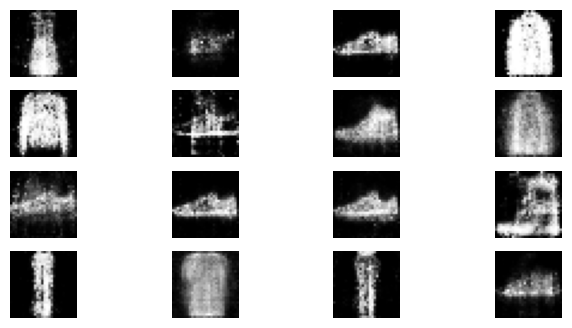

 62%|██████▏   | 31/50 [05:42<03:19, 10.52s/it]

Time for epoch 31 is 10.515461921691895 sec
Training started with  epoch 32 with 469 batches...
Losses after epoch    32: generator 1.484, discriminator 0.873, real_score 70.40%, fake_score 27.86%


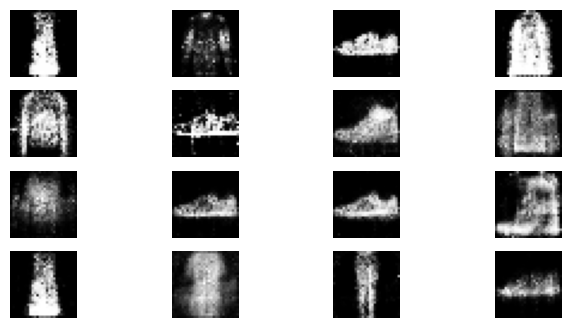

 64%|██████▍   | 32/50 [05:53<03:09, 10.54s/it]

Time for epoch 32 is 10.578640460968018 sec
Training started with  epoch 33 with 469 batches...
Losses after epoch    33: generator 2.362, discriminator 0.843, real_score 78.50%, fake_score 21.25%


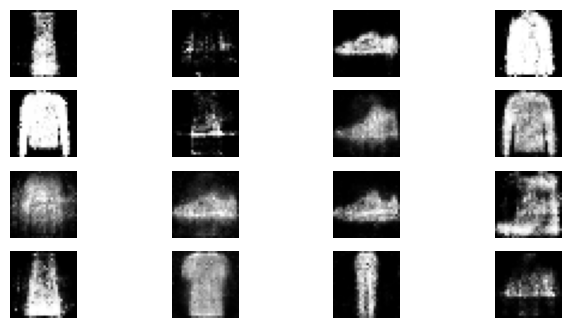

 66%|██████▌   | 33/50 [06:04<03:01, 10.66s/it]

Time for epoch 33 is 10.938223600387573 sec
Training started with  epoch 34 with 469 batches...
Losses after epoch    34: generator 1.406, discriminator 0.978, real_score 69.00%, fake_score 31.76%


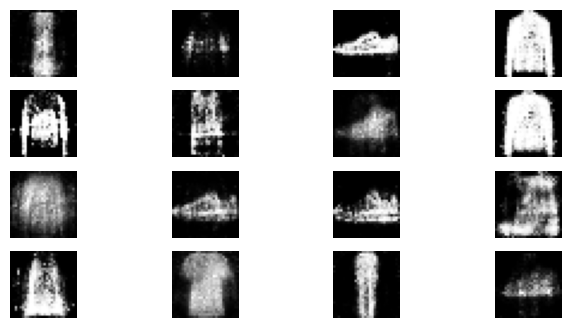

 68%|██████▊   | 34/50 [06:14<02:45, 10.36s/it]

Time for epoch 34 is 9.654980421066284 sec
Training started with  epoch 35 with 469 batches...
Losses after epoch    35: generator 3.598, discriminator 0.431, real_score 85.62%, fake_score 12.41%


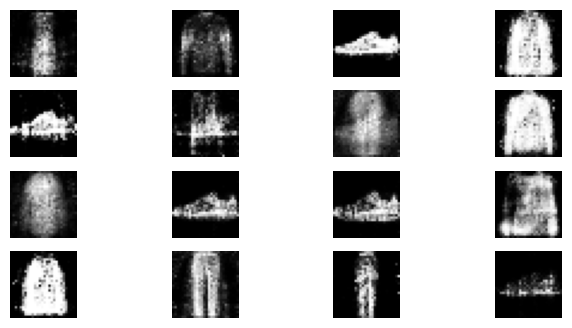

 70%|███████   | 35/50 [06:24<02:33, 10.26s/it]

Time for epoch 35 is 10.031479120254517 sec
Training started with  epoch 36 with 469 batches...
Losses after epoch    36: generator 2.179, discriminator 0.681, real_score 74.36%, fake_score 20.73%


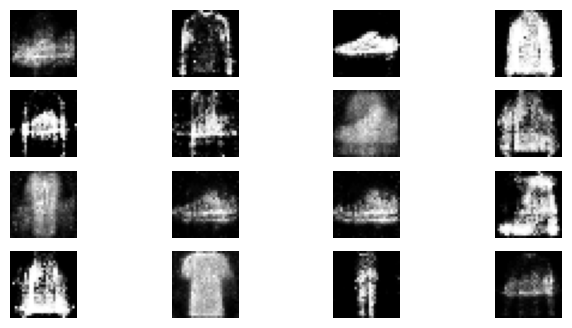

 72%|███████▏  | 36/50 [06:34<02:24, 10.30s/it]

Time for epoch 36 is 10.386864185333252 sec
Training started with  epoch 37 with 469 batches...
Losses after epoch    37: generator 2.291, discriminator 0.610, real_score 79.30%, fake_score 17.49%


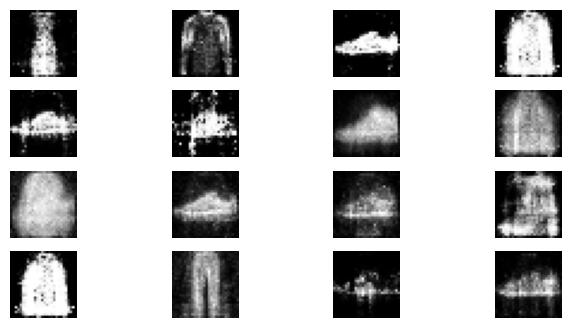

 74%|███████▍  | 37/50 [06:45<02:16, 10.50s/it]

Time for epoch 37 is 10.966719627380371 sec
Training started with  epoch 38 with 469 batches...
Losses after epoch    38: generator 1.384, discriminator 0.879, real_score 71.16%, fake_score 31.97%


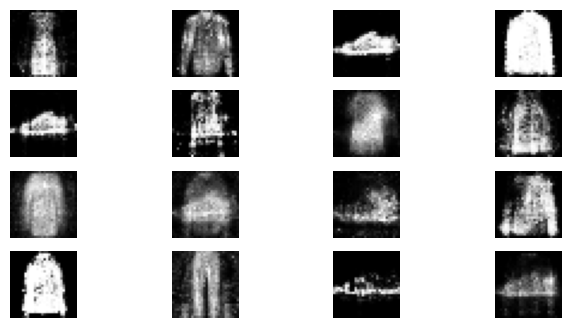

 76%|███████▌  | 38/50 [06:56<02:06, 10.54s/it]

Time for epoch 38 is 10.606086730957031 sec
Training started with  epoch 39 with 469 batches...
Losses after epoch    39: generator 3.105, discriminator 0.557, real_score 82.41%, fake_score 14.17%


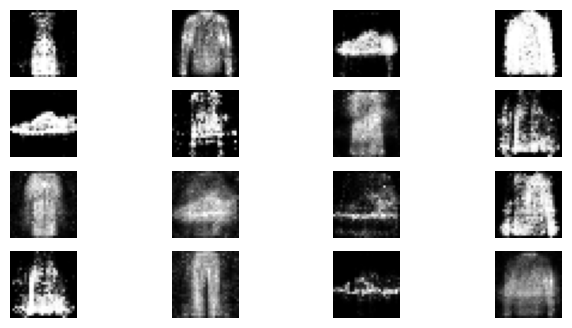

 78%|███████▊  | 39/50 [07:06<01:55, 10.49s/it]

Time for epoch 39 is 10.362929344177246 sec
Training started with  epoch 40 with 469 batches...
Losses after epoch    40: generator 2.489, discriminator 0.931, real_score 73.43%, fake_score 22.93%


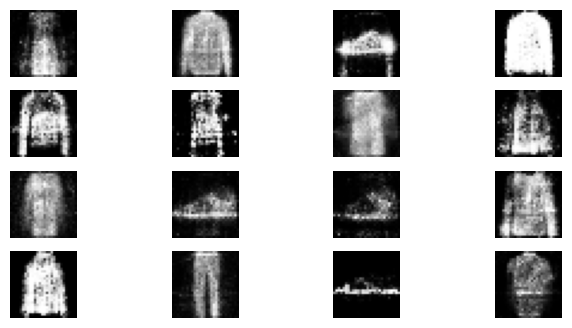

 80%|████████  | 40/50 [07:16<01:43, 10.30s/it]

Time for epoch 40 is 9.85933542251587 sec
Training started with  epoch 41 with 469 batches...
Losses after epoch    41: generator 1.095, discriminator 1.163, real_score 61.49%, fake_score 38.28%


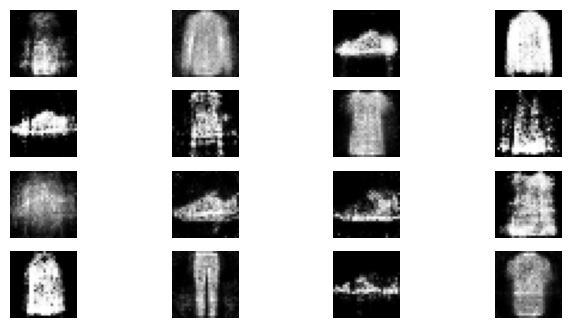

 82%|████████▏ | 41/50 [07:27<01:35, 10.56s/it]

Time for epoch 41 is 11.166370391845703 sec
Training started with  epoch 42 with 469 batches...
Losses after epoch    42: generator 1.780, discriminator 1.011, real_score 66.57%, fake_score 29.23%


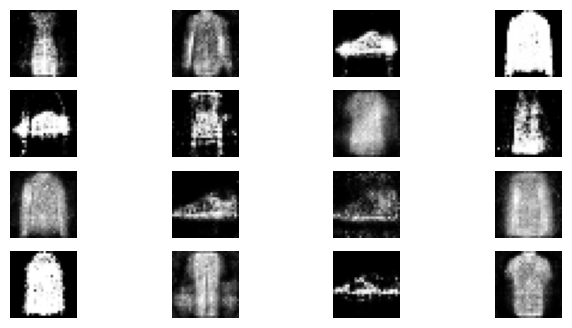

 84%|████████▍ | 42/50 [07:38<01:25, 10.65s/it]

Time for epoch 42 is 10.859708070755005 sec
Training started with  epoch 43 with 469 batches...
Losses after epoch    43: generator 1.965, discriminator 0.790, real_score 75.02%, fake_score 24.63%


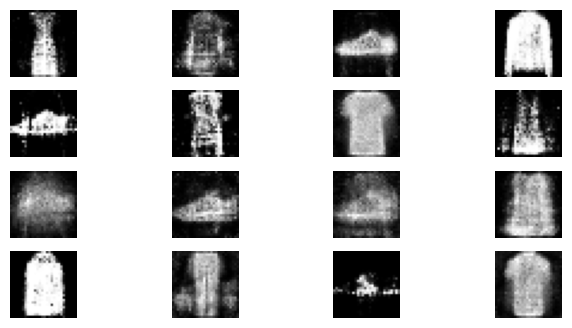

 86%|████████▌ | 43/50 [07:49<01:14, 10.67s/it]

Time for epoch 43 is 10.708669424057007 sec
Training started with  epoch 44 with 469 batches...
Losses after epoch    44: generator 1.834, discriminator 0.846, real_score 77.85%, fake_score 25.62%


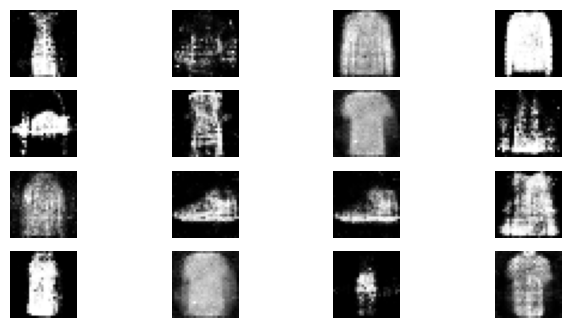

 88%|████████▊ | 44/50 [07:59<01:04, 10.70s/it]

Time for epoch 44 is 10.765046834945679 sec
Training started with  epoch 45 with 469 batches...
Losses after epoch    45: generator 2.303, discriminator 0.747, real_score 80.39%, fake_score 19.51%


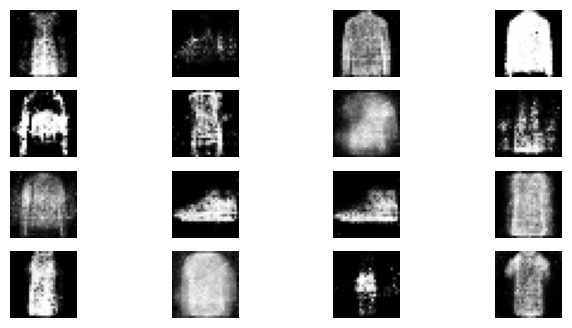

 90%|█████████ | 45/50 [08:12<00:56, 11.20s/it]

Time for epoch 45 is 12.359743356704712 sec
Training started with  epoch 46 with 469 batches...
Losses after epoch    46: generator 2.175, discriminator 0.588, real_score 76.36%, fake_score 17.17%


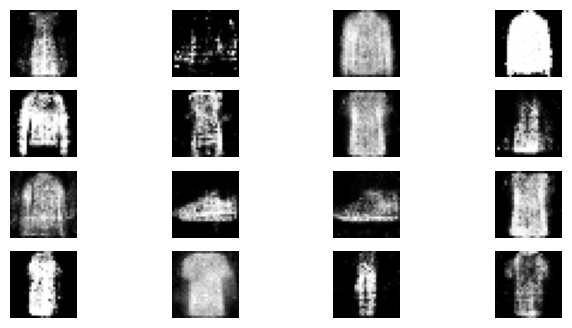

 92%|█████████▏| 46/50 [08:22<00:43, 10.96s/it]

Time for epoch 46 is 10.382327318191528 sec
Training started with  epoch 47 with 469 batches...
Losses after epoch    47: generator 2.120, discriminator 0.879, real_score 76.73%, fake_score 28.75%


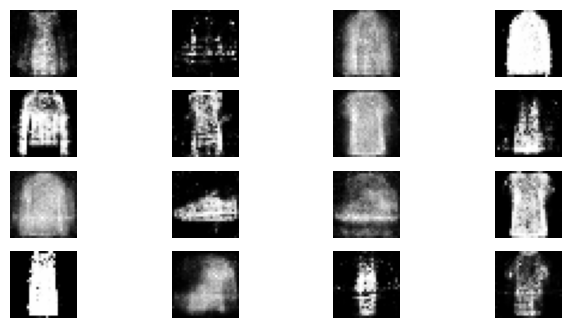

 94%|█████████▍| 47/50 [08:33<00:32, 10.82s/it]

Time for epoch 47 is 10.500268936157227 sec
Training started with  epoch 48 with 469 batches...
Losses after epoch    48: generator 2.039, discriminator 0.977, real_score 66.63%, fake_score 23.72%


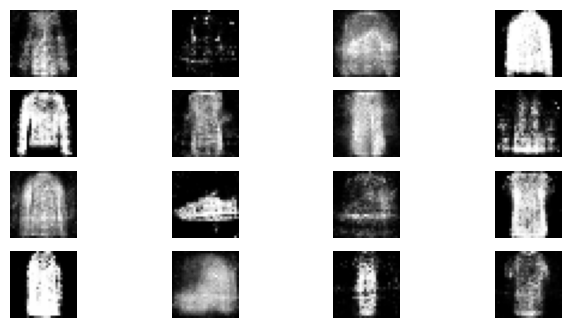

 96%|█████████▌| 48/50 [08:43<00:21, 10.82s/it]

Time for epoch 48 is 10.799885034561157 sec
Training started with  epoch 49 with 469 batches...
Losses after epoch    49: generator 2.315, discriminator 0.539, real_score 82.22%, fake_score 20.70%


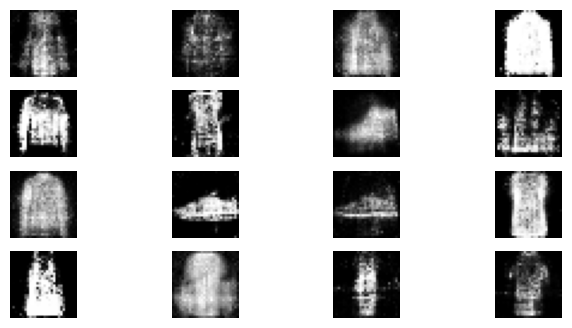

 98%|█████████▊| 49/50 [08:54<00:10, 10.85s/it]

Time for epoch 49 is 10.913506746292114 sec
Training started with  epoch 50 with 469 batches...
Losses after epoch    50: generator 1.896, discriminator 1.256, real_score 62.27%, fake_score 27.27%


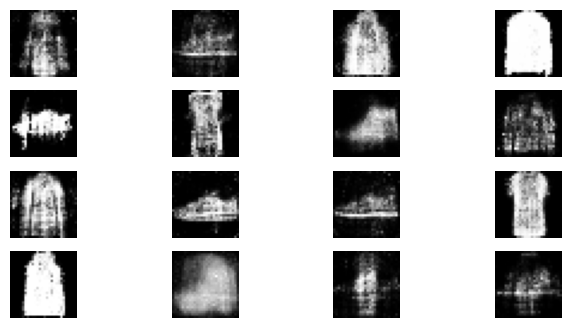

100%|██████████| 50/50 [09:06<00:00, 10.92s/it]

Time for epoch 50 is 11.408088207244873 sec


In [38]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs = epochs)

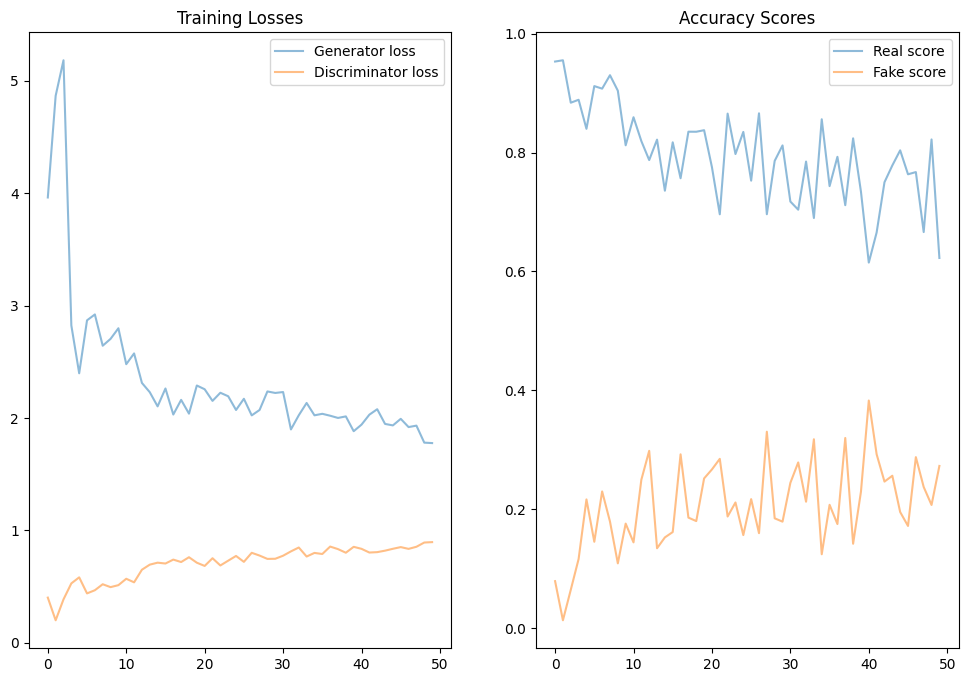

In [39]:
#Plotting visualisations for Losses and Scores
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()